In [146]:
# What version of Python do you have?
import sys
from tensorflow import keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
import os
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
#print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


Python Platform: Windows-10-10.0.19045-SP0
Tensor Flow Version: 2.13.0

Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:14:58) [MSC v.1929 64 bit (AMD64)]
Pandas 2.0.3
Scikit-Learn 1.3.0
GPU is NOT AVAILABLE


In [147]:
dataset = 'dataset'

In [148]:
# Lista para almacenar las rutas de las imágenes y sus etiquetas (hombre: 0, mujer: 1)
X = []
y = []

In [149]:
clases = os.listdir(dataset)
for clase in clases:
    ruta_clase = os.path.join(dataset, clase)
    if not os.path.isdir(ruta_clase):
        continue

    etiqueta = 0 if clase == 'hombre' else 1
    for imagen_nombre in os.listdir(ruta_clase):
        ruta_imagen = os.path.join(ruta_clase, imagen_nombre)

        X.append(ruta_imagen)
        y.append(etiqueta)

In [150]:
# Convertir las listas en arrays numpy
X = np.array(X)
y = np.array(y)

In [151]:
# Dividir los datos en conjunto de entrenamiento, validación y prueba
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_train_temp, y_train_temp, test_size=0.1, random_state=42)

In [152]:
# Redimensionar las imágenes a 128x128
def resize_images(images, new_size):
    resized_images = []
    for image_path in images:
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, (new_size, new_size))
        resized_images.append(resized_image)
    return np.array(resized_images)

new_size = 128
X_train_resized = resize_images(X_train_temp, new_size)
X_val_resized = resize_images(X_val, new_size)
X_test_resized = resize_images(X_test, new_size)

In [153]:
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [154]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


In [155]:
base_model.trainable = False

In [156]:
# Agregar capas personalizadas al modelo
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

In [157]:
# Construir el modelo completo
model = Model(inputs=base_model.input, outputs=output)

In [158]:
from tensorflow.keras.optimizers.legacy import Adam, SGD

In [159]:
# Compilar el modelo
#model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [160]:
# Entrenar el modelo
epochs = 50
batch_size = 32 # 32, 64, 128
model.fit(X_train_resized, y_train_temp, epochs=epochs, batch_size=batch_size, validation_data=(X_val_resized, y_val))

Epoch 1/50
14/14 [==============================] - 9s 482ms/step - loss: 0.7342 - accuracy: 0.5787 - val_loss: 0.6955 - val_accuracy: 0.5928
Epoch 2/50
14/14 [==============================] - 5s 402ms/step - loss: 0.6847 - accuracy: 0.6343 - val_loss: 0.6671 - val_accuracy: 0.6082
Epoch 3/50
14/14 [==============================] - 6s 406ms/step - loss: 0.6584 - accuracy: 0.6204 - val_loss: 0.6427 - val_accuracy: 0.6392
Epoch 4/50
14/14 [==============================] - 5s 403ms/step - loss: 0.6329 - accuracy: 0.6435 - val_loss: 0.6230 - val_accuracy: 0.6572
Epoch 5/50
14/14 [==============================] - 6s 409ms/step - loss: 0.6162 - accuracy: 0.6551 - val_loss: 0.6076 - val_accuracy: 0.6701
Epoch 6/50
14/14 [==============================] - 6s 416ms/step - loss: 0.6027 - accuracy: 0.6806 - val_loss: 0.5978 - val_accuracy: 0.6804
Epoch 7/50
14/14 [==============================] - 6s 414ms/step - loss: 0.5897 - accuracy: 0.6898 - val_loss: 0.5845 - val_accuracy: 0.6959
Epoch 

In [161]:
# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test_resized)
y_pred_labels = np.round(y_pred).flatten()

2/2 [==============================] - 1s 97ms/step


In [162]:
# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)
conf_matrix = confusion_matrix(y_test, y_pred_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1-score:", f1)
#print("Confusion Matrix:")
#print(conf_matrix)

Accuracy: 0.8409090909090909
Recall: 0.7619047619047619
F1-score: 0.8205128205128205


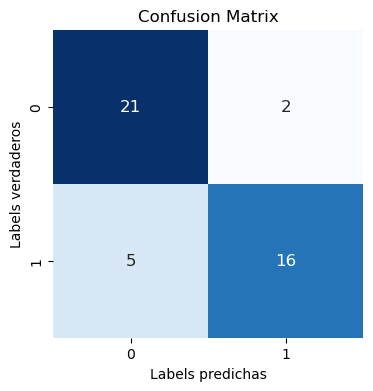

In [163]:
# Visualizar la matriz de confusión con Seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12})
plt.xlabel('Labels predichas')
plt.ylabel('Labels verdaderos')
plt.title('Confusion Matrix')
plt.show()